<a href="https://colab.research.google.com/github/blacktruth513/CodeStates_Project/blob/main/AI_03_Section4%20Project_%EC%B5%9C%ED%98%84%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d utmhikari/doubanmovieshortcomments
!unzip doubanmovieshortcomments.zip

Saving kaggle.json to kaggle (2).json
doubanmovieshortcomments.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  doubanmovieshortcomments.zip
replace DMSC.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DMSC.csv                y



 <img src='https://i.imgur.com/RDAD11M.png' width = '200' align = 'right'>

# Section4 Project

---

#<center> **<딥러닝 NLP 기반 豆瓣 영화 리뷰 감정 분석 프로젝트>** </center>

---
<br>

##- 프로젝트 순서 - 
<br>

1.  프로젝트 주제  
<br>

2. 데이터 선정 이유 및 데이터 소개 / 프로젝트 문제 정의 
<br>

3. 데이터 전처리 
<br>

4.  
<br>

5. 타겟변수 및 베이스라인 모델 선정
<br>

6. 데이터 모델링 및 모델 해석
<br>

7. 최종 모델 선정 및 결론 도출 
<br>
<br>
<br>

# 1. 프로젝트 주제 

- 주어진 데이터를 활용하여 NLP 모델을 기반으로 영화 평점의 리뷰에 대한 감정 분석(분류)을 실시한다.  

# 2. 데이터 선정 이유 및 데이터 소개 / 프로젝트 문제 정의

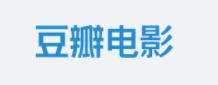

- 豆瓣电影은 중국의 영화 종합 사이트로서, 약 210만 개의 豆瓣의 리뷰, 평점 데이터를 사용하여 이번 섹션에서 배운 딥러닝 개념을 적용하여 통상적으로 쓰이는 영어 데이터가 아닌 중국어 데이터를 활용한 프로젝트를 수행함으로서, NLP(자연어 처리) 모델에 대한 이해를 확장시키는데 그 목적이 있다. 

- 문제 정의 : 주어진 데이터 타겟 변수인 평점에 대해 생성한 딥러닝 모델을 사용하여 특성 변수인 리뷰 데이터가 얼마나 특정 리뷰의 평점을 잘 예측하는지 진행하려고한다. 

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('./DMSC.csv', low_memory=False)

In [4]:
df

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723
...,...,...,...,...,...,...,...,...,...,...
2125051,2125051,Zootopia,疯狂动物城,2017-01-04,141196,猫的烟火尾巴,2016-03-06,4,真好看 兔子警官又美有善良又可爱~简直理想结婚对象！每一个动物造型都是那么赞~,0
2125052,2125052,Zootopia,疯狂动物城,2017-01-04,141197,Tosta,2016-03-05,5,六星好评！像头脑特工队那样惊喜！,0
2125053,2125053,Zootopia,疯狂动物城,2017-01-04,141198,風立ちぬ,2016-03-11,4,欢乐而又深刻，是童话故事更是政治寓言。,0
2125054,2125054,Zootopia,疯狂动物城,2017-01-04,141199,P I T T,2016-03-05,5,对现实世界歧视和偏见的影射妙哉妙哉，不要害怕打破常规，try everything,0


In [ ]:
!pip install histograms

  Created wheel for histograms: filename=histograms-1.0.0-py3-none-any.whl size=7083 sha256=3c02376be4f09e96dad21dd785dbbe5a23d62dba6b371ec1b5fa60e27472ad0a
  Stored in directory: /root/.cache/pip/wheels/02/8e/7c/5dac0e89caead901fab4d4629bb5008d2cc3481e0ece573253
Successfully built histograms


In [6]:
# 전처리 라이브러리 
import numpy as np
import jieba
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

# 모델링 라이브러리 
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, GlobalAveragePooling1D, Input, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

 # 시각화 라이브러리 
import matplotlib.pyplot as plt
import seaborn as sns
#from histograms import histograms

In [7]:
df.dtypes

ID                int64
Movie_Name_EN    object
Movie_Name_CN    object
Crawl_Date       object
Number            int64
Username         object
Date             object
Star              int64
Comment          object
Like              int64
dtype: object

In [8]:
# N/A 값 확인 및 제거 
df.isnull().sum()
df = df.dropna()

In [9]:
# 평점 재분류 // 부정(0), 중립(1), 긍정(2)
def restar(row):
    if row == 1:
        return 0
    elif row == 2:
        return 0
    elif row == 3:
        return 1
    elif row == 4:
        return 2
    elif row == 5:
        return 2    

df['Star'] = df['Star'].apply(restar)
df['Star'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0          1
1          0
2          0
3          2
4          0
          ..
2125051    2
2125052    2
2125053    2
2125054    2
2125055    2
Name: Star, Length: 2124907, dtype: object

In [10]:
print(df['Star'].unique())
print(df['Star'].value_counts())

[1 0 2]
2    1279804
1     474532
0     370571
Name: Star, dtype: int64


### 중국어 토크나이징 프로세스 with Jieba

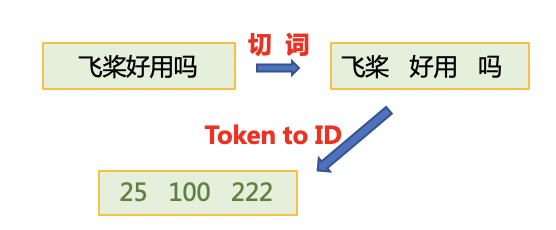

In [11]:
# 불용어 사전 정리 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r').readlines()] 
    return stopwords 

stopwords = stopwordslist('/content/drive/MyDrive/AI_Bootcamp/Data/百度停用词表.txt')

print('------------------------ 불용어 사전 ------------------------------------')
print(stopwords)

# token 분리  # 32분 소요
def chinese_word_cut(mytext):
    mytext = " ".join([w for w in list(jieba.cut(mytext)) if w not in stopwords])
    return " ".join(jieba.cut(mytext))

------------------------ 불용어 사전 ------------------------------------
['--', '?', '“', '”', '》', '－－', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', "a's", 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', "c'mon", 'co', 'com', 'come', 'comes', 'concerni

In [12]:
df['Comment'] = df['Comment'].apply(chinese_word_cut)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.793 seconds.
Prefix dict has been built successfully.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
# 토크나이징 결과 확인
df['Comment'].head(100)

0                              奥创   都   整容   去   韩国   。
1         失望   ，   剧本   敷衍了事   ，   主线   剧情   没   突破 ...
2         2015   年度   最   失望   作品   。   面面俱到   ，   实...
3         《   铁人   2   中   勾引   钢铁   侠   ，   《   妇联 ...
4                    从头   打 到   尾   ，   真的   很   无聊   。
                            ...                        
95                                             Shi   剧情
96        通篇   洋溢着   「   鸡巴   大   先   说   」   直   男 ...
97        刘大勇   你好   ！   字幕   翻译   太烂   ，   节奏   不连贯...
98        笑   点   满满   ，   热血   高能   前作   相比   ，   一...
99        复联   基本上   情景喜剧   路线   上   拍   ，   人   固定 ...
Name: Comment, Length: 100, dtype: object

In [14]:
# 특성 변수 및 타겟 선정
X = df.Comment.astype('str') # 특성변수
y = df['Star'] ## 타겟변수(0-2) 

# 데이터 분할 // 학습/검증/테스트(6:2:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # 트레인 - 테스트셋 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42) # 트레인 - 검증셋 분리

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(1359940,) (1359940,) (339985,) (339985,) (424982,) (424982,)


In [19]:
# 문서 평균 길이
print(f'Mean length of train set: {np.mean([len(sent) for sent in X_train], dtype=int)}')

Mean length of train set: 76


In [20]:
#단어 토크나이징
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train) # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성

In [22]:
## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tokenizer.word_index.items()): # 단어별 id값 할당 
    if ii < 50:
        print(iterm)
    else:
        break
print("===================")  
for ii,iterm in enumerate(tokenizer.word_counts.items()): # 단어 카운트 
    if ii < 20:
        print(iterm)
    else:
        break

('，', 1)
('。', 2)
('！', 3)
('看', 4)
('很', 5)
('电影', 6)
('都', 7)
('不', 8)
('好', 9)
('…', 10)
('人', 11)
('剧情', 12)
('还', 13)
('？', 14)
('不错', 15)
('说', 16)
('没', 17)
('喜欢', 18)
('太', 19)
('好看', 20)
('一个', 21)
('真的', 22)
('去', 23)
('感觉', 24)
('故事', 25)
('特效', 26)
('笑', 27)
('一部', 28)
('想', 29)
('、', 30)
('画面', 31)
('挺', 32)
('会', 33)
('上', 34)
('完', 35)
('这部', 36)
('最', 37)
('中', 38)
('片子', 39)
('拍', 40)
('点', 41)
('小', 42)
('演技', 43)
('里', 44)
('很多', 45)
('中国', 46)
('国产', 47)
('看过', 48)
('爱', 49)
('大', 50)
('希望', 19610)
('最最', 487)
('昂贵', 51)
('东西', 13512)
('说', 98462)
('特别', 20656)
('好看', 90970)
('，', 2208894)
('喜欢', 93019)
('。', 1127406)
('岳父', 1538)
('脑', 2715)
('残粉', 2680)
('手', 2448)
('撕', 5884)
('闺蜜', 2699)
('拍', 42104)
('出新', 403)
('高度', 2225)
('挺好玩', 517)


In [23]:
y_train.value_counts()

2    818938
1    304027
0    236975
Name: Star, dtype: int64

In [24]:
#texts_to_sequences (단어 벡터화)
train_seq = tokenizer.texts_to_sequences(X_train)
valid_seq = tokenizer.texts_to_sequences(X_valid)
test_seq = tokenizer.texts_to_sequences(X_test)

In [25]:
# padding(문장 길이 픽스)
train_pad = sequence.pad_sequences(train_seq, maxlen=max_len)
valid_pad = sequence.pad_sequences(valid_seq, maxlen=max_len)
test_pad = sequence.pad_sequences(test_seq, maxlen=max_len)

print(train_pad.shape)
print(valid_pad.shape)
print(test_pad.shape)

(1359940, 100)
(339985, 100)
(424982, 100)


In [ ]:
# 랜덤 시드 고정 
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
## 모델 정의
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.00001),   
                activity_regularizer=regularizers.l1(0.00001), name='FC1')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(3,activation='softmax',name='FC2')(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 128)          640128    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 3)                 387       
Total params: 788,611
Trainable params: 788,611
Non-trainable params: 0
_____________________________________________________

In [ ]:
## 모델링
model_fit = model.fit(train_pad, y_train, batch_size=128, epochs=2,
                      validation_data=(valid_pad, y_valid), verbose=1)

Epoch 1/2
10625/10625 [==============================] - 2804s 264ms/step - loss: 0.6617 - accuracy: 0.7159 - val_loss: 0.6348 - val_accuracy: 0.7273
Epoch 2/2
10625/10625 [==============================] - 2782s 262ms/step - loss: 0.6269 - accuracy: 0.7327 - val_loss: 0.6206 - val_accuracy: 0.7345


In [ ]:
accuracy = model.evaluate(test_pad, y_test)

13281/13281 [==============================] - 393s 30ms/step - loss: 0.6201 - accuracy: 0.7344


In [ ]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accuracy[0], accuracy[1]))

Test set
  Loss: 0.6201
  Accuracy: 0.7344


In [ ]:
# Plot training & validation loss values
# 5. 모델 학습과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

NameError: ignored

In [ ]:
test_review = model.predict(test_pad)

In [ ]:
test_review

array([[0.17719398, 0.7957126 , 0.02709345],
       [0.04872093, 0.24941914, 0.70185983],
       [0.6642057 , 0.22151949, 0.11427486],
       ...,
       [0.05404098, 0.2704087 , 0.6755503 ],
       [0.06819758, 0.42684188, 0.5049606 ],
       [0.4672143 , 0.389381  , 0.14340484]], dtype=float32)

In [125]:
y_test.iloc[[500]]

1592432    0
Name: Star, dtype: int64

In [ ]:
model.predict(test_pad[500])

array([[0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.21234842, 0.23368226, 0.5539693 ],
       [0.

In [ ]:
X_test.iloc[500]

'    看   四娘   真的   真的   很   努力   ，   没   办法   抢救   …   …'

In [15]:
test_review = pd.concat([X_test, y_test], axis=1)

In [17]:
test_review.iloc[10000:10051]

,Comment,Star
591121,三藏和段小姐的爱情故事~还可以 笑点都有点冷啊 和大话西游不好比的啊 观众确实也越来越难伺...,1
1279107,场景设计，人物造型，3D特效加分，据说是广电下命令不能怪力乱神所以瞎编了很多应付的？那这电...,1
1034653,导演还是有一定水平的，两次反转这种至少很对我胃口。（最打动我的是七月第一次找到工作跑像家明...,2
1801610,男主一行人找到大部队，却被勒令离开...我有点搞不懂那群人怎么想的。（就算要走，走的也应该...,2
1744273,还是那句话 最可怕的是人心 不过我也没法站在道德的制高点上去判断好坏，在限定的紧急情况下，...,2
126948,人物关系很恶心，对话很矫情，在电影院看跟看老炮儿一样坐着很恼火，要睡着！,0
554577,非常不错，笑中带泪。忍不住想看第二遍,2
780211,理想之境（LA LA LAND）永远丰满迷人，而现实是，有所得必有所失。导演的取向在开头场...,1
1338755,本来抱着又一国产烂片的目的去看的 结果貌似各方面都没什么缺陷 有笑点有情节有特效 尤...,2
953498,黄晓明和杨幂还能要求多少呢？女主中学时期不能走心点找顶好看的假发吗？跟个老太婆似的。片中加...,0
